In [1]:
import sys
sys.version

'3.7.1 (v3.7.1:260ec2c36a, Oct 20 2018, 03:13:28) \n[Clang 6.0 (clang-600.0.57)]'

In [2]:
# 外部依存なしでやっていき
import math
from typing import Callable, Union, TypeVar
from dataclasses import dataclass

In [3]:
# なんかへん，突然，型ヒントの先読みが聞かなくなった（3.7の目玉機能）
Differentiable = TypeVar('Differentiable')

# 微分可能な関数
@dataclass
class Differentiable:
    f: Callable[[float], float]
    d: Callable[[float], float]
        
    # 関数の合成
    def __call__(self, other: Differentiable) -> Differentiable:
        return Differentiable(
            f=lambda x: self.f(other.f(x)),
            d=lambda x: self.d(other.f(x))*other.d(x)
        )
    
    # 足し算
    def __add__(self, other: Union[Differentiable, float, int]) -> Differentiable:
        # pythonには多相関数がないので場合分け
        if isinstance(other, Differentiable): 
            return Differentiable(
                f=lambda x: self.f(x) + other.f(x),
                d=lambda x: self.d(x) + other.d(x)
            )
        
        elif isinstance(other, (int, float)):
            return Differentiable(
                f=lambda x: self.f(x) + other,
                d=lambda x: self.d(x) 
            )
        
        else:
            raise Exception("Invalid operation has been given.")
    
    # 加法逆元
    def __neg__(self) -> Differentiable:
        return Differentiable(
            f=lambda x: -self.f(x),
            d=lambda x: -self.d(x)
        )

    # 引き算
    def __sub__(self, other: Union[Differentiable, float, int]) -> Differentiable:
        return self + (-other)
    
    # 掛け算
    def __mul__(self, other: Union[Differentiable, float, int]) -> Differentiable:
        if isinstance(other, Differentiable):
            return Differentiable(
                f=lambda x: self.f(x)*other.f(x),
                d=lambda x: self.f(x)*other.d(x) + self.d(x)*other.f(x)
            )
        
        elif isinstance(other, (int, float)):
            return Differentiable(
                f=lambda x: self.f(x)*other,
                d=lambda x: self.d(x)*other
            )
        
        else:
            raise Exception("Invalid operation has been given.")
    
    # 割り算
    def __truediv__(self, other: Union[Differentiable, float, int]) -> Differentiable:
        if isinstance(other, Differentiable):
            return Differentiable(
                f=lambda x: self.f(x) / other.f(x),
                d=lambda x: (self.d(x)*other.f(x) - self.f(x)*other.d(x)) / (other.f(x)**2)
            )
        
        elif isinstance(other, (float, int)):
            return Differentiable(
                f=lambda x: self.f(x)/other,
                d=lambda x: self.d(x)/other
            )

        else:
            raise Exception("Invalid operation has been given.")
    
    # 累乗
    def __pow__(self, n: int) -> Differentiable:
        assert n > 0, "Given n needs to be positive"
        assert isinstance(n, int), "Given n needs to be integer"
        
        # 末尾再帰にしたい
        def rec(d: Differentiable, n) -> Differentiable:
            if n == 1:
                return d
            
            else:
                return rec(d * self, n-1)
            
        return rec(self, n)
    
    def evaluate(self, x: float) -> float:
        return self.f(x)
    
    def evaluate_derivative(self, x: float) -> float:
        return self.d(x)

In [4]:
# 基本的な関数
class BasicDiffentiable:
    x = Differentiable(f=lambda x: x, d=lambda x: 1)
    sin = Differentiable(f=lambda x: math.sin(x), d=lambda x: math.cos(x))
    cos = Differentiable(f=lambda x: math.cos(x), d=lambda x: -math.sin(x))
    exp = Differentiable(f=lambda x: math.exp(x), d=lambda x: math.exp(x))

# エイリアス
D = BasicDiffentiable

In [5]:
# エイリアス
x = D.x
sin = D.sin

In [6]:
# 基本的な関数の加減乗除，合成で作られた関数
y = (x - 5)*(x + 3)
z = sin(y)**2

In [7]:
# 評価してみる
y.evaluate(5.0)

0.0

In [8]:
# 導関数を評価してみる
y.evaluate_derivative(5.0)

8.0

In [9]:
# 以後可視化
import pandas as pd
import seaborn as sns

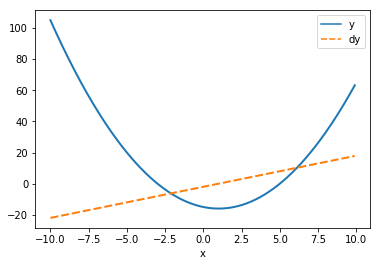

In [10]:
# y とその導関数
data = {
    'x': [k*0.1 for k in range(-100, 100)],
    'y': [y.evaluate(k*0.1) for k in range(-100, 100)],
    'dy': [y.evaluate_derivative(k*0.1) for k in range(-100, 100)],
}
df = pd.DataFrame(data).set_index('x')
sns.lineplot(data=df, linewidth=2)

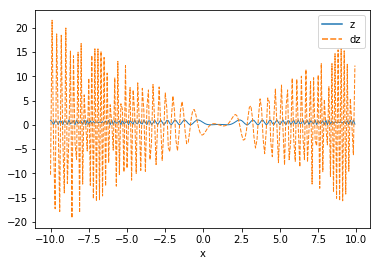

In [11]:
# z とその導関数
data = {
    'x': [k*0.1 for k in range(-100, 100)],
    'z': [z.evaluate(k*0.1) for k in range(-100, 100)],
    'dz': [z.evaluate_derivative(k*0.1) for k in range(-100, 100)],
}
df = pd.DataFrame(data).set_index('x')
sns.lineplot(data=df, linewidth=1)